# Adding a New Forecasting Model

This notebook provides a minimal example on how to add a new forecasting model to Merlion. We follow the instructions in [CONTRIBUTING.md](https://github.com/salesforce/Merlion/blob/main/CONTRIBUTING.md). We suggest you review this [notebook](1_ForecastFeatures.ipynb) explaining how to use a Merlion forecasting model before reading this one.

More specifically, let's implement a forecasting model whose forecast is just equal to the most recent observed value of the time series metric. For a more complete example, see our implementation of `Sarima` [here](https://github.com/salesforce/Merlion/blob/main/merlion/models/forecast/sarima.py).

## Model Config Class

The first step of creating a new model is defining an appropriate config class, which inherits from `ForecasterConfig`:

In [1]:
from merlion.models.forecast.base import ForecasterConfig

class RepeatRecentConfig(ForecasterConfig):
    def __init__(self, max_forecast_steps=None, **kwargs):
        super().__init__(max_forecast_steps=max_forecast_steps, **kwargs)


## Model Class

Next we define the model itself, which must inherit from the `ForecasterBase` base class and define all abstract methods. See the API docs for more details.

In [2]:
from collections import OrderedDict
from typing import List, Tuple

from merlion.models.forecast.base import ForecasterBase
from merlion.utils import TimeSeries, UnivariateTimeSeries


class RepeatRecent(ForecasterBase):
    # The config class for RepeatRecent is RepeatRecentConfig, defined above
    config_class = RepeatRecentConfig
    
    def __init__(self, config):
        """
        Sets the model config and any other local variables. Here, we initialize
        the most_recent_value to None.
        """
        super().__init__(config)
        self.most_recent_value = None
    
    
    def train(self, train_data: TimeSeries, train_config=None) -> Tuple[TimeSeries, None]:
        # Apply training preparation steps. We specify that this model doesn't
        # require evenly sampled time series, and it doesn't require univariate
        # data.
        train_data = self.train_pre_process(
            train_data, require_even_sampling=False, require_univariate=False)
        
        # "Train" the model. Here, we just gather the most recent values
        # for each univariate in the time series.
        self.most_recent_value = OrderedDict((k, v.values[-1]) 
                                             for k, v in train_data.items())
        
        # The model's "prediction" for the training data, is just the value
        # from one step before.
        train_forecast = TimeSeries(OrderedDict(
            (name, UnivariateTimeSeries(univariate.time_stamps,
                                        [0] + univariate.values[:-1]))
            for name, univariate in train_data.items()))
        
        # This model doesn't have any notion of error
        train_stderr = None
        
        # Return the train prediction & standard error
        return train_forecast, train_stderr
    
    def forecast(self, time_stamps: List[int],
                 time_series_prev: TimeSeries = None,
                 return_iqr=False, return_prev=False
                ) -> Tuple[TimeSeries, None]:

        # Use time_series_prev's most recent value if time_series_prev is given.
        # Make sure to apply the data pre-processing transform on it first!
        if time_series_prev is not None:
            time_series_prev = self.transform(time_series_prev)
            most_recent_value = {k: v.values[-1] for k, v in time_series_prev.items()}
        
        # Otherwise, use the most recent value stored from the training data
        else:
            most_recent_value = self.most_recent_value
        
        # The forecast is just the most recent value repeated for every upcoming
        # timestamp
        forecast = TimeSeries(OrderedDict(
            (k, UnivariateTimeSeries(time_stamps, [v] * len(time_stamps)))
            for k, v in most_recent_value.items()))
        
        # Pre-pend time_series_prev to the forecast if desired
        if return_prev and time_series_prev is not None:
            forecast = time_series_prev + forecast
        
        # Ensure we're not trying to return an inter-quartile range
        if return_iqr:
            raise RuntimeError(
                "RepeatRecent model doesn't support uncertainty estimation")
        
        return forecast, None


## Running the Model: A Simple Example

Let's try running this model on some actual data! This next part assumes you've installed `ts_datasets`. We'll begin by getting a time series from the M4 dataset & visualizing it.

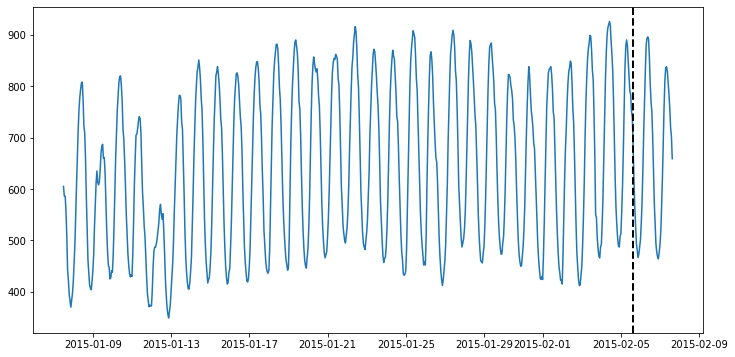

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

from ts_datasets.forecast import M4

time_series, metadata = M4(subset="Hourly")[0]

# Visualize the full time series
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(time_series)

# Label the train/test split with a dashed line
ax.axvline(time_series[metadata["trainval"]].index[-1], ls="--", lw=2, c="k")

plt.show()

Now, we'll split the data into train & test splits, and run our forecasting model on it.

In [4]:
train_data = TimeSeries.from_pd(time_series[metadata["trainval"]])
test_data  = TimeSeries.from_pd(time_series[~metadata["trainval"]])

In [5]:
# Initialize a model & train it. The dataframe returned & printed
# below is the model's "forecast" on the training data. None is 
# the uncertainty estimate.
model = RepeatRecent(RepeatRecentConfig())
model.train(train_data=train_data)

(                        H1
 2015-01-07 12:00:00    0.0
 2015-01-07 13:00:00  605.0
 2015-01-07 14:00:00  586.0
 2015-01-07 15:00:00  586.0
 2015-01-07 16:00:00  559.0
 ...                    ...
 2015-02-05 11:00:00  820.0
 2015-02-05 12:00:00  790.0
 2015-02-05 13:00:00  784.0
 2015-02-05 14:00:00  752.0
 2015-02-05 15:00:00  739.0
 
 [700 rows x 1 columns],
 None)

In [6]:
# Let's run our model on the test data now
forecast, err = model.forecast(test_data.to_pd().index)
print("Forecast")
print(forecast)
print()
print("Error")
print(err)

Forecast
                        H1
2015-02-05 16:00:00  684.0
2015-02-05 17:00:00  684.0
2015-02-05 18:00:00  684.0
2015-02-05 19:00:00  684.0
2015-02-05 20:00:00  684.0
2015-02-05 21:00:00  684.0
2015-02-05 22:00:00  684.0
2015-02-05 23:00:00  684.0
2015-02-06 00:00:00  684.0
2015-02-06 01:00:00  684.0
2015-02-06 02:00:00  684.0
2015-02-06 03:00:00  684.0
2015-02-06 04:00:00  684.0
2015-02-06 05:00:00  684.0
2015-02-06 06:00:00  684.0
2015-02-06 07:00:00  684.0
2015-02-06 08:00:00  684.0
2015-02-06 09:00:00  684.0
2015-02-06 10:00:00  684.0
2015-02-06 11:00:00  684.0
2015-02-06 12:00:00  684.0
2015-02-06 13:00:00  684.0
2015-02-06 14:00:00  684.0
2015-02-06 15:00:00  684.0
2015-02-06 16:00:00  684.0
2015-02-06 17:00:00  684.0
2015-02-06 18:00:00  684.0
2015-02-06 19:00:00  684.0
2015-02-06 20:00:00  684.0
2015-02-06 21:00:00  684.0
2015-02-06 22:00:00  684.0
2015-02-06 23:00:00  684.0
2015-02-07 00:00:00  684.0
2015-02-07 01:00:00  684.0
2015-02-07 02:00:00  684.0
2015-02-07 03:00:00

## Visualization

Forecast w/ ground truth time series


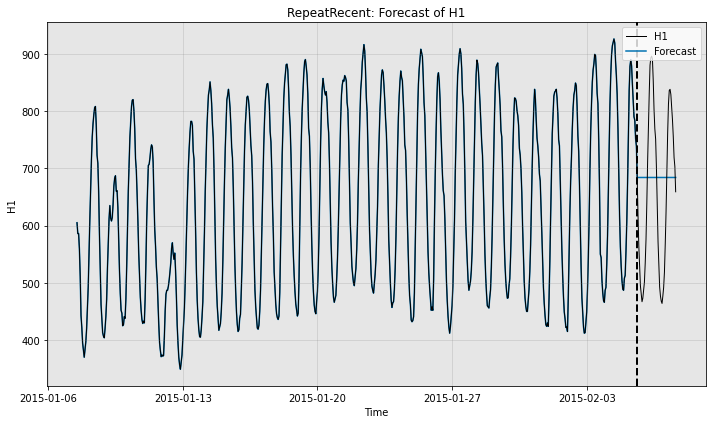


Forecast without ground truth time series


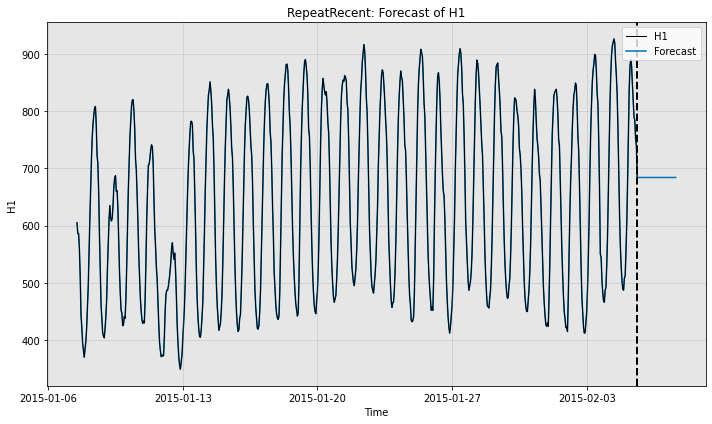

In [7]:
# Qualitatively, we can see what the forecaster is doing by plotting
print("Forecast w/ ground truth time series")
fig, ax = model.plot_forecast(time_series=test_data,
                              time_series_prev=train_data,
                              plot_time_series_prev=True)
plt.show()

print()
print("Forecast without ground truth time series")
fig, ax = model.plot_forecast(time_stamps=test_data.to_pd().index,
                              time_series_prev=train_data,
                              plot_time_series_prev=True)

## Quantitative Evaluation

You may quantitatively evaluate your model as well. Here, we compute the sMAPE (symmetric Mean Average Percent Error) of the model's forecast vs. the true data. For ground truth $y \in \mathbb{R}^T$ and prediction $\hat{y} \in \mathbb{R}^T$, the sMAPE is computed as

$$
\mathrm{sMAPE}(y, \hat{y}) = \frac{200}{T} \sum_{t = 1}^{T} \frac{\lvert \hat{y}_t - y_t \rvert}{\lvert\hat{y}_t\rvert + \lvert y_t \rvert}
$$

In [8]:
from merlion.evaluate.forecast import ForecastMetric
smape = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast)
print(f"sMAPE = {smape:.3f}")

sMAPE = 20.166


## Defining a Forecaster-Based Anomaly Detector

It is quite straightforward to adapt a forecasting model into an anomaly detection model. You just need to create a new file in the appropriate [directory](https://github.com/salesforce/Merlion/blob/main/merlion/models/anomaly/forecast_based) and define class stubs with some basic headers. Multiple inheritance with `ForecastingDetectorBase` takes care of most of the heavy lifting.

The anomaly score returned by any forecasting-based anomaly detector is based on the residual between the predicted and true time series values. 

In [9]:
from merlion.evaluate.anomaly import TSADMetric
from merlion.models.anomaly.forecast_based.base import ForecastingDetectorBase
from merlion.models.anomaly.base import DetectorConfig
from merlion.post_process.threshold import AggregateAlarms
from merlion.transform.normalize import MeanVarNormalize


# Define a config class which inherits from RepeatRecentConfig and DetectorConfig
# in that order
class RepeatRecentDetectorConfig(RepeatRecentConfig, DetectorConfig):
    # Set a default anomaly score post-processing rule
    _default_post_rule = AggregateAlarms(alm_threshold=3.0)
    
    # The default data pre-processing transform is mean-variance normalization,
    # so that anomaly scores are roughly aligned with z-scores
    _default_transform = MeanVarNormalize()

# Define a model class which inherits from ForecastingDetectorBase and RepeatRecent
# in that order
class RepeatRecentDetector(ForecastingDetectorBase, RepeatRecent):
    # All we need to do is set the config class
    config_class = RepeatRecentDetectorConfig

In [10]:
# Train the anomaly detection variant
model2 = RepeatRecentDetector(RepeatRecentDetectorConfig())
model2.train(train_data)

                     anom_score
2015-01-07 12:00:00   -0.212986
2015-01-07 13:00:00   -0.120839
2015-01-07 14:00:00    0.000000
2015-01-07 15:00:00   -0.171719
2015-01-07 16:00:00   -0.305278
...                         ...
2015-02-05 11:00:00   -0.190799
2015-02-05 12:00:00   -0.038160
2015-02-05 13:00:00   -0.203519
2015-02-05 14:00:00   -0.082679
2015-02-05 15:00:00   -0.349798

[700 rows x 1 columns]

In [11]:
# Obtain the anomaly detection variant's predictions on the test data
model2.get_anomaly_score(test_data)

                     anom_score
2015-02-05 16:00:00   -0.413397
2015-02-05 17:00:00   -0.756835
2015-02-05 18:00:00   -0.966714
2015-02-05 19:00:00   -1.202032
2015-02-05 20:00:00   -1.291072
2015-02-05 21:00:00   -1.380111
2015-02-05 22:00:00   -1.341952
2015-02-05 23:00:00   -1.246552
2015-02-06 00:00:00   -1.163873
2015-02-06 01:00:00   -0.953994
2015-02-06 02:00:00   -0.686876
2015-02-06 03:00:00   -0.286198
2015-02-06 04:00:00    0.178079
2015-02-06 05:00:00    0.559676
2015-02-06 06:00:00    0.928554
2015-02-06 07:00:00    1.246552
2015-02-06 08:00:00    1.329232
2015-02-06 09:00:00    1.348311
2015-02-06 10:00:00    1.316512
2015-02-06 11:00:00    1.081193
2015-02-06 12:00:00    0.756835
2015-02-06 13:00:00    0.540597
2015-02-06 14:00:00    0.426117
2015-02-06 15:00:00    0.108119
2015-02-06 16:00:00   -0.311638
2015-02-06 17:00:00   -0.712316
2015-02-06 18:00:00   -0.966714
2015-02-06 19:00:00   -1.214752
2015-02-06 20:00:00   -1.316512
2015-02-06 21:00:00   -1.373751
2015-02-

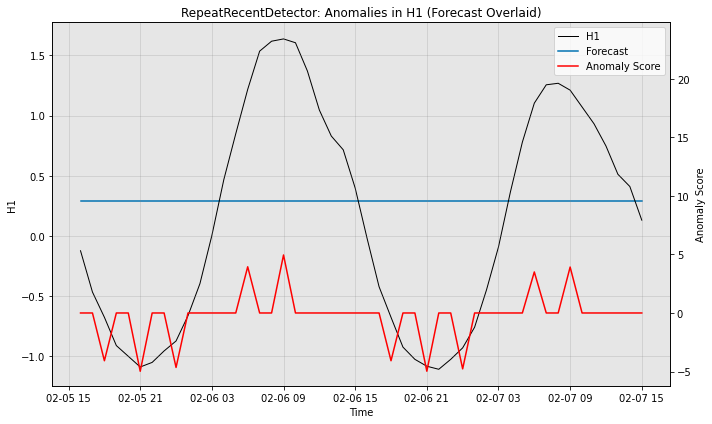

In [12]:
# Visualize the anomaly detection variant's performance, with filtered anomaly scores
fig, ax = model2.plot_anomaly(test_data, time_series_prev=train_data,
                              filter_scores=True, plot_time_series_prev=False,
                              plot_forecast=True)